# Домашнее задание № 9

### Задание 1 (5 баллов).
Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/transfer_learning_hg/Fine_tunining_pretrained_LMs.ipynb

Дообучите 3 предобученных модели на тех же данных, что и в семинаре. Сравните качество и выберите лучшую.
Модели должны отличаться друг от друга не только параметрами ru/en/multilingual, base/large, cased/uncased. Все три выбранные модели должны работать лучше, чем бейзлайн без дообучения (т.е. если модель не работает, попробуйте другую).


In [1]:
!pip install scikit-learn pandas matplotlib accelerate transformers keras -U

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.1.1


In [3]:
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report

import keras, torch
from transformers import AutoModel
from transformers import AutoTokenizer

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv("/content/drive/MyDrive/lenta_sample.csv")
data.dropna(subset=['topic', 'text'], inplace=True)

In [6]:
data

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2010/12/16/passports/,Московская милиция ужесточила паспортный режим,В Москве после серии массовых беспорядков на н...,Россия,Все,2010/12/16
1,https://lenta.ru/news/2014/05/19/student/,Московского студента ограбили на 6 миллионов р...,Неизвестные вынесли из квартиры московского ст...,Россия,NaN,2014/05/19
2,https://lenta.ru/news/2008/09/27/catch/,В Ставропольском крае обезврежены боевики,"В Ставропольском крае задержаны боевики, котор...",Россия,Все,2008/09/27
3,https://lenta.ru/news/2009/07/23/refuse/,Лужков отказался трудоустраивать китайцев с Че...,"Мэр Москвы Юрий Лужков заявил, что не намерен ...",Россия,Все,2009/07/23
4,https://lenta.ru/news/2012/09/29/factory/,По факту пожара на заводе в Югре заведено дело,Следственный комитет России возбудил уголовное...,Россия,Все,2012/09/29
...,...,...,...,...,...,...
602,https://lenta.ru/news/2014/09/14/pattern/,1914. Выкройки для раненых,"В дополнение к выкройкам белья для раненых, ра...",Библиотека,Первая мировая,2014/09/14
603,https://lenta.ru/news/2014/12/23/christmas/,1914. Немецкие и британские солдаты отметили п...,24 декабря в Бельгии в районе Ипра произошло н...,Библиотека,Первая мировая,2014/12/23
604,https://lenta.ru/news/2014/10/21/dobrovolec/,1914. Польский доброволец-герой,В числе поступивших в нашу армию добровольцев ...,Библиотека,Первая мировая,2014/10/21
605,https://lenta.ru/news/2014/09/18/postoffice/,1914. Письма в действующую армию на деревню де...,За последнее время на имя начальника штаба Вер...,Библиотека,Первая мировая,2014/09/18


## Замороженная предобученная модель

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
model_bert = AutoModel.from_pretrained("distilbert-base-multilingual-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

In [ ]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

In [ ]:
X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [ ]:
# Заморозка весов
for param in model_bert.parameters():
    param.requires_grad = False

In [7]:
class bert_wrapper(keras.Model):
    def __init__(self, model_bert, **kwargs):
        super().__init__(**kwargs)
        # модель нужно обернуть в специальный класс чтобы она была совместима с другими керас слоями
        self.model_bert = keras.layers.TorchModuleWrapper(model_bert)

    def call(self, inputs):
        x = self.model_bert(inputs)
        return x[0]

In [ ]:
input_word_ids = keras.layers.Input(shape=(512,), dtype='int32', name="input_ids")


output = bert_wrapper(model_bert)(input_word_ids)
drop = keras.layers.Dropout(0.1)(output[:, 0])
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=[input_word_ids], outputs=dense)

model_clf.compile(keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [ ]:
model_clf.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bert_wrapper (bert_wrapper)          │ (None, 512, 768)            │     134,734,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 17)                  │          13,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,747,153 (514.02 MB)

 Trainable params: 13,073 (51.07 KB)

 Non-trainable params: 134,734,080 (513.97 MB)

In [ ]:
if torch.cuda.is_available():
    model_clf.to('cuda')

In [ ]:
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train), validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)), batch_size=20, epochs=20)

Epoch 1/20


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 307ms/step - accuracy: 0.0750 - loss: 2.8383 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7326 - val_rec_prec: 0.0000e+00
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 301ms/step - accuracy: 0.0739 - loss: 2.7419 - rec_prec: 0.0000e+00 - val_accuracy: 0.0645 - val_loss: 2.6849 - val_rec_prec: 0.0000e+00
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 305ms/step - accuracy: 0.0891 - loss: 2.7217 - rec_prec: 0.0000e+00 - val_accuracy: 0.0645 - val_loss: 2.6758 - val_rec_prec: 0.0000e+00
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 311ms/step - accuracy: 0.0701 - loss: 2.7471 - rec_prec: 0.0020 - val_accuracy: 0.0968 - val_loss: 2.6749 - val_rec_prec: 0.0000e+00
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 309ms/step - accuracy: 0.1458 - loss: 2.6774 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.6820 - val_rec_prec: 0.0000e+00
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 312ms/step - accuracy: 0.0775 - loss: 2.7111 - rec_prec: 0.0000e+00 - val_accuracy:

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


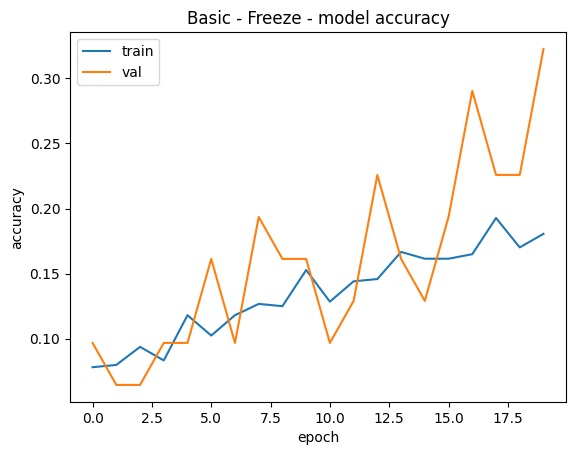

In [ ]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('Basic - Freeze - model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred = model_clf.predict(X_valid, batch_size=10).argmax(1)
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
                   precision    recall  f1-score   support

        Экономика       0.00      0.00      0.00         2
              Мир       0.00      0.00      0.00         1
            Спорт       0.33      1.00      0.50         2
  Наука и техника       0.00      0.00      0.00         3
      Бывший СССР       0.33      0.33      0.33         3
         Культура       1.00      0.33      0.50         3
           Бизнес       0.29      1.00      0.44         2
         Из жизни       1.00      0.33      0.50         3
   69-я параллель       0.00      0.00      0.00         1
             Крым       0.00      0.00      0.00         0
           Россия       0.00      0.00      0.00         2
              Дом       0.00      0.00      0.00         2
   Интернет и СМИ       0.00      0.00      0.00         2
          Легпром       0.00      0.00      0.00         1
       Библиотека       0.00      0.00      0.00         0
Силовые структур

## Twitter/twhin-bert-base

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Twitter/twhin-bert-base")
model_bert = AutoModel.from_pretrained("Twitter/twhin-bert-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at Twitter/twhin-bert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

In [ ]:
X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [ ]:
input_word_ids = keras.layers.Input(shape=(512,), dtype='int32', name="input_ids")

output = bert_wrapper(model_bert)(input_word_ids)
drop = keras.layers.Dropout(0.1)(output[:, 0])
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=[input_word_ids], outputs=dense)

model_clf.compile(keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [ ]:
model_clf.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bert_wrapper (bert_wrapper)          │ (None, 512, 768)            │     278,828,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 17)                  │          13,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 278,841,617 (1.04 GB)

 Trainable params: 278,841,617 (1.04 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
if torch.cuda.is_available():
    model_clf.to('cuda')

In [ ]:
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train),validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=4,
          epochs=10)

Epoch 1/10


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['variable_1', 'variable_209', 'variable_210'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 81s 530ms/step - accuracy: 0.0805 - loss: 2.9494 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7183 - val_rec_prec: 0.0000e+00
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 80s 556ms/step - accuracy: 0.0777 - loss: 2.7513 - rec_prec: 0.0000e+00 - val_accuracy: 0.0645 - val_loss: 2.7485 - val_rec_prec: 0.0000e+00
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 82s 571ms/step - accuracy: 0.0957 - loss: 2.7534 - rec_prec: 0.0030 - val_accuracy: 0.0968 - val_loss: 2.7046 - val_rec_prec: 0.0000e+00
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 83s 577ms/step - accuracy: 0.0925 - loss: 2.7321 - rec_prec: 0.0018 - val_accuracy: 0.1290 - val_loss: 2.6869 - val_rec_prec: 0.0645
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 83s 577ms/step - accuracy: 0.1084 - loss: 2.7132 - rec_prec: 1.9776e-04 - val_accuracy: 0.0968 - val_loss: 2.6998 - val_rec_prec: 0.0323
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 83s 576ms/step - accuracy: 0.1325 - loss: 2.6436 - rec_prec: 3.6003e-05 - val_accu

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


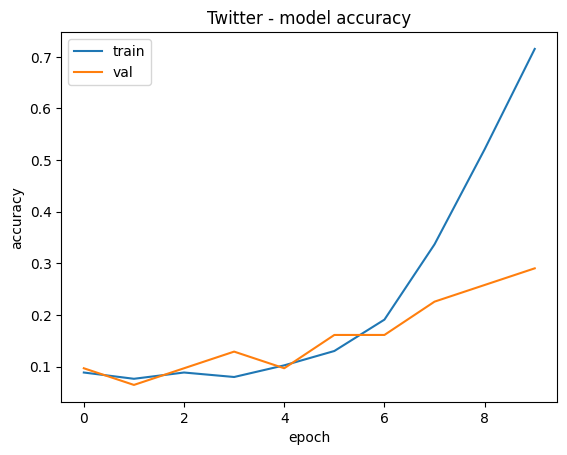

In [ ]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('Twitter - model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred = model_clf.predict(X_valid, batch_size=10).argmax(1)
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step
                   precision    recall  f1-score   support

            Спорт       1.00      1.00      1.00         2
           Бизнес       0.00      0.00      0.00         2
   Интернет и СМИ       0.12      0.50      0.20         2
      Бывший СССР       1.00      0.33      0.50         3
           Россия       0.00      0.00      0.00         2
         Культура       0.50      0.33      0.40         3
         Ценности       0.50      0.50      0.50         2
       Библиотека       0.00      0.00      0.00         0
  Наука и техника       0.20      0.33      0.25         3
              Дом       0.00      0.00      0.00         2
         Из жизни       0.67      0.67      0.67         3
          Легпром       0.00      0.00      0.00         1
        Экономика       0.00      0.00      0.00         2
Силовые структуры       0.00      0.00      0.00         2
              Мир       0.00      0.00      0.00         1
   69-я параллел

## Модель HooshvareLab/bert-base-parsbert-uncased

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model_bert = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

In [ ]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

In [ ]:
X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [ ]:
input_word_ids = keras.layers.Input(shape=(512,), dtype='int32', name="input_ids")


output = bert_wrapper(model_bert)(input_word_ids)
drop = keras.layers.Dropout(0.2)(output[:, 0])
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=[input_word_ids], outputs=dense)

model_clf.compile(keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [ ]:
model_clf.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bert_wrapper (bert_wrapper)          │ (None, 512, 768)            │     162,841,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 17)                  │          13,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,854,417 (621.24 MB)

 Trainable params: 162,854,417 (621.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
if torch.cuda.is_available():
    model_clf.to('cuda')

In [ ]:
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train),validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=4,
          epochs=10)

Epoch 1/10


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['variable_197', 'variable_198'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 62s 416ms/step - accuracy: 0.0764 - loss: 3.3140 - rec_prec: 0.0000e+00 - val_accuracy: 0.0645 - val_loss: 2.8550 - val_rec_prec: 0.0000e+00
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 62s 431ms/step - accuracy: 0.1005 - loss: 2.8789 - rec_prec: 0.0000e+00 - val_accuracy: 0.0323 - val_loss: 2.7743 - val_rec_prec: 0.0000e+00
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 62s 432ms/step - accuracy: 0.0826 - loss: 2.8969 - rec_prec: 0.0039 - val_accuracy: 0.0645 - val_loss: 2.7239 - val_rec_prec: 0.0000e+00
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 62s 434ms/step - accuracy: 0.0861 - loss: 2.9379 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7471 - val_rec_prec: 0.0000e+00
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 62s 433ms/step - accuracy: 0.0928 - loss: 2.8131 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.6866 - val_rec_prec: 0.0000e+00
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 62s 432ms/step - accuracy: 0.0975 - loss: 2.7643 - rec_prec: 5.1038e-0

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


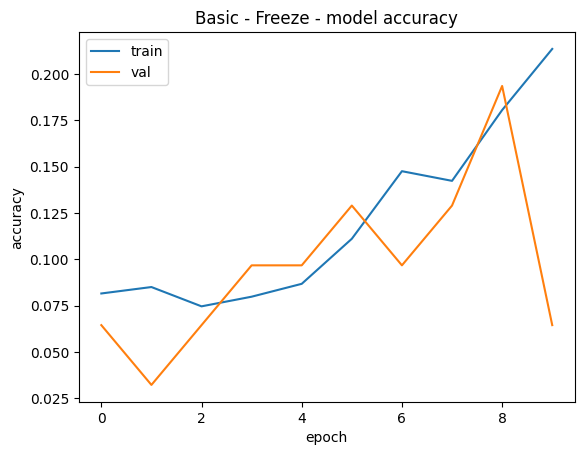

In [ ]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('Basic - Freeze - model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred = model_clf.predict(X_valid, batch_size=10).argmax(1)
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
                   precision    recall  f1-score   support

            Спорт       0.00      0.00      0.00         2
   Интернет и СМИ       0.00      0.00      0.00         2
           Бизнес       0.00      0.00      0.00         2
        Экономика       0.00      0.00      0.00         2
           Россия       0.00      0.00      0.00         2
              Мир       0.00      0.00      0.00         1
Силовые структуры       0.00      0.00      0.00         2
         Ценности       0.00      0.00      0.00         2
  Наука и техника       0.00      0.00      0.00         3
              Дом       0.00      0.00      0.00         2
   69-я параллель       0.00      0.00      0.00         1
         Из жизни       0.00      0.00      0.00         3
       Библиотека       0.00      0.00      0.00         0
             Крым       0.00      0.00      0.00         0
          Легпром       0.00      0.00      0.00         1
      Бывший ССС

## Модель plAIground/xlmr-bert-multilingual-base-merge

In [8]:
tokenizer = AutoTokenizer.from_pretrained("plAIground/xlmr-bert-multilingual-base-merge")
model_bert = AutoModel.from_pretrained("plAIground/xlmr-bert-multilingual-base-merge")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.83G [00:00<?, ?B/s]

In [9]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

In [10]:
X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [11]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [12]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [23]:
input_word_ids = keras.layers.Input(shape=(512,), dtype='int32', name="input_ids")


output = bert_wrapper(model_bert)(input_word_ids)
drop = keras.layers.Dropout(0.1)(output[:, 0])
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=[input_word_ids], outputs=dense)

model_clf.compile(keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [24]:
model_clf.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bert_wrapper_2 (bert_wrapper)        │ (None, 512, 768)            │     278,043,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_2 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 17)                  │          13,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 278,056,721 (1.04 GB)

 Trainable params: 278,056,721 (1.04 GB)

 Non-trainable params: 0 (0.00 B)

In [25]:
if torch.cuda.is_available():
    model_clf.to('cuda')

In [27]:
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train),validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=4,
          epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['variable_595', 'variable_596'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 69s 479ms/step - accuracy: 0.0643 - loss: 2.9890 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7249 - val_rec_prec: 0.0000e+00
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 68s 475ms/step - accuracy: 0.0901 - loss: 2.7922 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7340 - val_rec_prec: 0.0000e+00
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 68s 474ms/step - accuracy: 0.0797 - loss: 2.8354 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7291 - val_rec_prec: 0.0000e+00
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 68s 475ms/step - accuracy: 0.0989 - loss: 2.7487 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7076 - val_rec_prec: 0.0000e+00
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 68s 475ms/step - accuracy: 0.0567 - loss: 2.7858 - rec_prec: 0.0014 - val_accuracy: 0.0968 - val_loss: 2.7063 - val_rec_prec: 0.0000e+00
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 68s 475ms/step - accuracy: 0.0780 - loss: 2.8076 - rec_prec: 0.0000e+0

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


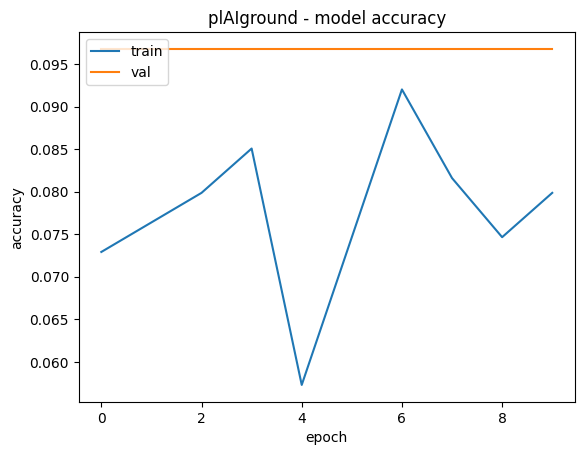

In [28]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('plAIground - model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
pred = model_clf.predict(X_valid, batch_size=10).argmax(1)
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
                   precision    recall  f1-score   support

        Экономика       0.00      0.00      0.00         2
            Спорт       0.00      0.00      0.00         2
   Интернет и СМИ       0.00      0.00      0.00         2
         Культура       0.00      0.00      0.00         3
  Наука и техника       0.10      1.00      0.18         3
           Бизнес       0.00      0.00      0.00         2
       Библиотека       0.00      0.00      0.00         0
              Мир       0.00      0.00      0.00         1
         Из жизни       0.00      0.00      0.00         3
           Россия       0.00      0.00      0.00         2
         Ценности       0.00      0.00      0.00         2
   69-я параллель       0.00      0.00      0.00         1
             Крым       0.00      0.00      0.00         0
          Легпром       0.00      0.00      0.00         1
Силовые структуры       0.00      0.00      0.00         2
              До

Твиттер победил...

### Задание 2 (5 баллов).

Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/gpt/gpt.ipynb

Попробуйте дообучать GPT на каком-то другом тексте (можете попробовать любые стихи или какие-то специфичные вещи вроде анекдотов или репа).
Попробуйте разные методы и параметры генерации (beam search, температура, top_k и тп). Сохраните в тетрадке несколько хороших сгенерированных текстов.

Можете использовать другую модель.


In [7]:
from transformers.utils import logging
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
DEVICE = torch.device("cuda:0")

# Загружаем модель ruGPT от сбера
model_name_or_path = "sberbank-ai/rugpt3small_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)
model = GPT2LMHeadModel.from_pretrained(model_name_or_path, use_cache=False).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

### **"Илиада" мучила меня на первом курсе, теперь моя очередь**
Поместим в переменную песнь первую.

In [8]:
import re

In [9]:
iliada = """
Гнев, богиня, воспой Ахиллеса, Пелеева сына,  Грозный, который ахеянам тысячи бедствий соделал:  Многие души могучие славных героев низринул  В мрачный Аид и самих распростер их в корысть плотоядным 5 Птицам окрестным и псам (совершалася Зевсова воля),  С оного дня, как, воздвигшие спор, воспылали враждою  Пастырь народов Атрид и герой Ахиллес благородный.  Кто ж от богов бессмертных подвиг их к враждебному спору?  Сын громовержца и Леты - Феб, царем прогневленный, 10 Язву на воинство злую навел; погибали народы  В казнь, что Атрид обесчестил жреца непорочного Хриса.  Старец, он приходил к кораблям быстролетным ахейским  Пленную дочь искупить и, принесши бесчисленный выкуп  И держа в руках, на жезле золотом, Аполлонов 15 Красный венец, умолял убедительно всех он ахеян,  Паче ж Атридов могучих, строителей рати ахейской:  "Чада Атрея и пышнопоножные мужи ахейцы!  О! да помогут вам боги, имущие домы в Олимпе,  Град Приамов разрушить и счастливо в дом возвратиться; 20 Вы ж свободите мне милую дочь и выкуп примите,  Чествуя Зевсова сына, далеко разящего Феба".
 Все изъявили согласие криком всеобщим ахейцы  Честь жрецу оказать и принять блистательный выкуп;  Только царя Агамемнона было то не любо сердцу; 25 Гордо жреца отослал и прирек ему грозное слово:  "Старец, чтоб я никогда тебя не видал пред судами!  Здесь и теперь ты не медли и впредь не дерзай показаться!  Или тебя не избавит ни скиптр, ни венец Аполлона.  Деве свободы не дам я; она обветшает в неволе, 30 В Аргосе, в нашем дому, от тебя, от отчизны далече -  Ткальньй стан обходя или ложе со мной разделяя.  Прочь удались и меня ты не гневай, да здрав возвратишься!"
 Рек он; и старец трепещет и, слову царя покоряся,  Идет, безмолвный, по брегу немолчношумящей пучины. 35 Там, от судов удалившися, старец взмолился печальный  Фебу царю, лепокудрыя Леты могущему сыну:  "Бог сребролукий, внемли мне: о ты, что, хранящий, обходишь  Хрису, священную Киллу и мощно царишь в Тенедосе,  Сминфей! если когда я храм твой священный украсил, 40 Если когда пред тобой возжигал я тучные бедра  Коз и тельцов, - услышь и исполни одно мне желанье:  Слезы мои отомсти аргивянам стрелами твоими!"
 Так вопиял он, моляся; и внял Аполлон сребролукий:  Быстро с Олимпа вершин устремился, пышущий гневом, 45 Лук за плечами неся и колчан, отовсюду закрытый;  Громко крылатые стрелы, биясь за плечами, звучали  В шествии гневного бога: он шествовал, ночи подобный.  Сев наконец пред судами, пернатую быструю мечет;  Звон поразительный издал серебряный лук стреловержца. 50 В самом начале на месков напал он и псов празднобродных;  После постиг и народ, смертоносными прыща стрелами;  Частые трупов костры непрестанно пылали по стану.
 Девять дней на воинство божие стрелы летали;  В день же десятый Пелид на собрание созвал ахеян. 55 В мысли ему то вложила богиня державная Гера:  Скорбью терзалась она, погибающих видя ахеян.  Быстро сходился народ, и, когда воедино собрался,  Первый, на сонме восстав, говорил Ахиллес быстроногий:  "Должно, Атрид, нам, как вижу, обратно исплававши море, 60 В домы свои возвратиться, когда лишь от смерти спасемся.  Вдруг и война, и погибельный мор истребляет ахеяи.  Но испытаем, Атрид, и вопросим жреца, иль пророка,  Или гадателя снов (и сны от Зевеса бывают):  Пусть нам поведают, чем раздражен Аполлон небожитель? 65 Он за обет несвершенный, за жертву ль стотельчую гневен?  Или от агнцев и избранных коз благовонного тука  Требует бог, чтоб ахеян избавить от пагубной язвы?"
 Так произнесши, воссел Ахиллес; и мгновенно от сонма  Калхас восстал Фесторид, верховный птицегадатель. 70 Мудрый, ведал он все, что минуло, что есть и что будет,  И ахеян суда по морям предводил к Илиону  Даром предвиденья, свыше ему вдохновенным от Феба.  Он, благомыслия полный, речь говорил и вещал им:  "Царь Ахиллес! возвестить повелел ты, любимец Зевеса, 75 Праведный гнев Аполлона, далеко разящего бога?  Я возвещу; но и ты согласись, поклянись мне, что верно  Сам ты меня защитить и словами готов и руками.  Я опасаюсь, прогневаю мужа, который верховный  Царь аргивян и которому все покорны ахейцы. 80 Слишком могуществен царь, на мужа подвластного гневный?  Вспыхнувший гнев он на первую пору хотя и смиряет,  Но сокрытую злобу, доколе ее не исполнит,  В сердце хранит. Рассуди ж и ответствуй, заступник ли ты мне?"
 Быстро ему отвечая, вещал Ахиллес благородный: 85 "Верь и дерзай, возвести нам оракул, какой бы он ни был!  Фебом клянусь я, Зевса любимцем, которому, Калхас,  Молишься ты, открывая данаям вещания бога:  Нет, пред судами никто, покуда живу я и вижу,  Рук на тебя дерзновенных, клянуся, никто не подымет 90 В стане ахеян; хотя бы назвал самого ты Атрида,  Властию ныне верховной гордящегось в рати ахейской".
 Рек он; и сердцем дерзнул, и вещал им пророк непорочный:  "Нет, не за должный обет, не за жертву стотельчую гневен  Феб, но за Хриса жреца: обесчестил его Агамемнон, 95 Дщери не выдал ему и моленье и выкуп отринул.  Феб за него покарал, и бедами еще покарает,  И от пагубной язвы разящей руки не удержит  Прежде, доколе к отцу не отпустят, без платы, свободной  Дщери его черноокой и в Хрису святой не представят 100 Жертвы стотельчей; тогда лишь мы бога на милость преклоним".
 Слово скончавши, воссел Фесторид; и от сонма воздвигся  Мощный герой, пространно-властительный царь Агамемнон,  Гневом волнуем; ужасной в груди его мрачное сердце  Злобой наполнилось; очи его засветились, как пламень. 105 Калхасу первому, смотря свирепо, вещал Агамемнон:  "Бед предвещатель, приятного ты никогда не сказал мне!  Радостно, верно, тебе человекам беды лишь пророчить;  Доброго слова еще ни измолвил ты нам, ни исполнил.  Се, и теперь ты для нас как глагол проповедуешь бога, 110 Будто народу беды дальномечущий Феб устрояет,  Мстя, что блестящих даров за свободу принять Хрисеиды  Я не хотел; но в душе я желал черноокую деву  В дом мой ввести; предпочел бы ее и самой Клитемнестре,  Девою взятой в супруги; ее Хрисеида не хуже 115 Прелестью вида, приятством своим, и умом, и делами!  Но соглашаюсь, ее возвращаю, коль требует польза:  Лучше хочу я спасение видеть, чем гибель народа.  Вы ж мне в сей день замените награду, да в стане аргивском  Я без награды один не останусь: позорно б то было; 120 Вы же то видите все - от меня отходит награда".
 Первый ему отвечал Пелейон, Ахиллес быстроногий!  "Славою гордый Атрид, беспредельно корыстолюбивый!  Где для тебя обрести добродушным ахеям награду?  Мы не имеем нигде сохраняемых общих сокровищ: 125 Что в городах разоренных мы добыли, все разделили;  Снова ж, что было дано, отбирать у народа - позорно!  Лучше свою возврати, в угождение богу. Но после  Втрое и вчетверо мы, аргивяне, тебе то заплатим,  Если дарует Зевс крепкостеиную Трою разрушить".
 130 Быстро, к нему обратяся, вещал Агамемнон могучий:  "Сколько ни доблестен ты, Ахиллес, бессмертным подобный,  Хитро не умствуй: меня ни провесть, ни склонить не успеешь.  Хочешь, чтоб сам обладал ты наградой, а я чтоб, лишенный,  Молча сидел? и советуешь мне ты, чтоб деву я выдал?.. 135 Пусть же меня удовольствуют новою мздою ахейцы,  Столько ж приятною сердцу, достоинством равною первой.  Если ж откажут, предстану я сам и из кущи исторгну  Или твою, иль Аяксову мзду, или мзду Одиссея;  Сам я исторгну, и горе тому, пред кого я предстану! 140 Но об этом беседовать можем еще мы и после.  Ныне черный корабль на священное море ниспустим,  Сильных гребцов изберем, на корабль гекатомбу поставим  И сведем Хрисеиду, румяноланитую деву.  В нем да воссядет начальником муж от ахеян советных, 145 Идоменей, Одиссей Лаэртид иль Аякс Теламонид  Или ты сам, Пелейон, из мужей в ополченье страшнейший!  Шествуй и к нам Аполлона умилостивь жертвой священной!"
 Грозно взглянув на него, отвечал Ахиллес быстроногий:  "Царь, облеченный бесстыдством, коварный душою мздолюбец! 150 Кто из ахеян захочет твои повеления слушать?  Кто иль поход совершит, иль с враждебными храбро сразится?  Я за себя ли пришел, чтоб троян, укротителей коней,  Здесь воевать? Предо мною ни в чем не виновны трояне:  Муж их ни коней моих, ни тельцов никогда не похитил; 155 В счастливой Фтии моей, многолюдной, плодами обильной,  Нив никогда не топтал; беспредельные нас разделяют  Горы, покрытые лесом, и шумные волны морские.  Нет, за тебя мы пришли, веселим мы тебя, на троянах  Чести ища Менелаю, тебе, человек псообразный! 160 Ты же, бесстыдный, считаешь ничем то и все презираешь,  Ты угрожаешь и мне, что мою ты награду похитишь,  Подвигов тягостных мзду, драгоценнейший дар мне ахеян?..  Но с тобой никогда не имею награды я равной,  Если троянский цветущий ахеяне град разгромляют. 165 Нет, несмотря, что тягчайшее бремя томительной брани  Руки мои подымают, всегда, как раздел наступает,  Дар богатейший тебе, а я и с малым, приятным  В стан не ропща возвращаюсь, когда истомлен ратоборством.  Ныне во Фтию иду: для меня несравненно приятней 170 В дом возвратиться на быстрых судах; посрамленный тобою,  Я не намерен тебе умножать здесь добыч и сокровищ".
 Быстро воскликнул к нему повелитель мужей Агамемнон:  "Что же, беги, если бегства ты жаждешь! Тебя не прошу я  Ради меня оставаться; останутся здесь и другие; 175 Честь мне окажут они, а особенно Зевс промыслитель.  Ты ненавистнейший мне меж царями, питомцами Зевса!  Только тебе и приятны вражда, да раздоры, да битвы.  Храбростью ты знаменит; но она дарование бога.  В дом возвратясь, с кораблями беги и с дружиной своею; 180 Властвуй своими фессальцами! Я о тебе не забочусь;  Гнев твой вменяю в ничто; а, напротив, грожу тебе так я:  Требует бог Аполлон, чтобы я возвратил Хрисеиду;  Я возвращу, - и в моем корабле и с моею дружиной  Деву пошлю; но к тебе я приду, и из кущи твоей Брисеиду 185 Сам увлеку я, награду твою, чтобы ясно ты понял,  Сколько я властию выше тебя, и чтоб каждый страшился  Равным себя мне считать и дерзко верстаться со мною!"
 Рек он, - и горько Пелиду то стало: могучее сердце  В персях героя власатых меж двух волновалося мыслей: 190 Или, немедля исторгнувши меч из влагалища острый,  Встречных рассыпать ему и убить властелина Атрида;  Или свирепство смирить, обуздав огорченную душу.  В миг, как подобными думами разум и душу волнуя,  Страшный свой меч из ножон извлекал он, - явилась Афина, 195 С неба слетев; ниспослала ее златотронная Гера,  Сердцем любя и храня обоих браноносцев; Афина,  Став за хребтом, ухватила за русые кудри Пелида,  Только ему лишь явленная, прочим незримая в сонме.  Он ужаснулся и, вспять обратяся, познал несомненно 200 Дочь громовержцеву: страшным огнем ее очи горели.  К ней обращенный лицом, устремил он крылатые речи:  "Что ты, о дщерь Эгиоха, сюда низошла от Олимпа?  Или желала ты видеть царя Агамемнона буйство?  Но реку я тебе, и реченное скоро свершится: 205 Скоро сей смертный своею гордынею душу погубит!"
 Сыну Пелея рекла светлоокая дщерь Эгиоха:  "Бурный твой гнев укротить я, когда ты бессмертным покорен,  С неба сошла; ниспослала меня златотронная Гера;  Вас обоих равномерно и любит она, и спасает. 210 Кончи раздор, Педейон, и, довольствуя гневное сердце,  Злыми словами язви, но рукою меча не касайся.  Я предрекаю, и оное скоро исполнено будет:  Скоро трикраты тебе знаменитыми столько ж дарами  Здесь за обиду заплатят: смирися и нам повинуйся".
 215 К ней обращайся вновь, говорил Ахиллес быстроногий:  "Должно, о Зевсова дщерь, соблюдать повеления ваши.  Как мой ни пламенен гнев, .но покорность полезнее будет:  Кто бессмертным покорен, тому и бессмертные внемлют".
 Рек, и на сребряном черене стиснул могучую руку 220 И огромный свой меч в ножны опустил, покоряся  Слову Паллады; Зевсова дочь вознеслася к Олимпу,  В дом Эгиоха отца, небожителей к светлому сонму.  Но Пелид быстроногий суровыми снова словами  К сыну Атрея вещал и отнюдь необуздывал гнева: 225 "Грузный вином, со взорами песьими, с сердцем еленя!  Ты никогда ни в сраженье открыто стать перед войском,  Ни пойти на засаду с храбрейшими рати мужами  Сердцем твоим не дерзнул: для тебя то кажется смертью.  Лучше и легче стократ по широкому стану ахеян 230 Грабить дары у того, кто тебе прекословить посмеет.  Царь пожиратель народа! Зане над презренными царь ты, -  Или, Атрид, ты нанес бы обиду, последнюю в жизни!  Но тебе говорю, и великою клятвой клянуся,  Скипетром сим я клянуся, который ни листьев, ни ветвей 235 Вновь не испустит, однажды оставив свой корень на холмах,  Вновь не прозябнет, - на нем изощренная медь обнажила  Листья и кору, - и ныне который ахейские мужи  Носят в руках судии, уставов Зевесовых стражи, -  Скиптр сей тебе пред ахейцами будет великою клятвой: 240 Время придет, как данаев сыны пожелают Пелида .  Все до последнего; ты ж, и крушася, бессилен им будешь  Помощь подать, как толпы их от Гектора мужеубийцы  Свергнутся в прах; и душой ты своей истерзаешься, бешен  Сам на себя, что ахейца храбрейшего так обесславил".
 245 Так произнес, и на землю стремительно скипетр он бросил,  Вкруг золотыми гвоздями блестящий, и сел меж царями.  Против Атрид Агамемнон свирепствовал сидя; и  Нестор Сладкоречивый восстал, громогласный вития пилосский:  Речи из уст его вещих, сладчайшие меда, лилися. 250 Два поколенья уже современных ему человеков  Скрылись, которые некогда с ним возрастали и жили  В Пилосе пышном; над третьим уж племенем царствовал старец.  Он, благомыслия полный, советует им и вещает:  "Боги! великая скорбь на ахейскую землю приходит! 255 О! возликует Приам и Приамовы гордые чада,  Все обитатели Трои безмерно восхитятся духом,  Если услышат, что вы воздвигаете горькую распрю, -  Вы, меж данаями первые в сонмах и первые в битвах!  Но покоритесь, могучие! оба меня вы моложе, 260 Я уже древле видал знаменитейших вас браноносцев;  С ними в беседы вступал, и они не гнушалися мною.  Нет, подобных мужей не видал я и видеть не буду,  Воев, каков Пирифой и Дриас, предводитель народов,  Грозный Эксадий, Кеней, Полифем, небожителям равный, 265 И рожденный Эгеем Тесей, бессмертным подобный!  Се человеки могучие, слава сынов земнородных!  Были могучи они, с могучими в битвы вступали,  С лютыми чадами гор, и сражали их боем ужасным.  Был я, однако, и с оными в дружестве, бросивши Пилос, 270 Дальную Апии землю: меня они вызвали сами.  Там я, по силам моим, подвизался; но с ними стязаться  Кто бы дерзнул от живущих теперь человеков наземных?  Но и они мой совет принимали и слушали речи.  Будьте и вы послушны: слушать советы полезно. 275 Ты, Агамемнон, как ни могущ, не лишай Ахиллеса  Девы: ему как награду ее даровали ахейцы.  Ты, Ахиллес, воздержись горделиво с царем препираться:  Чести подобной доныне еще не стяжал ни единый  Царь скиптроносец, которого Зевс возвеличивал славой. 280 Мужеством ты знаменит, родила тебя матерь-богиня;  Но сильнейший здесь он, повелитель народов несчетных.  Сердце смири, Агамемнон: я, старец, тебя умоляю,  Гнев отложи на Пелида героя, который сильнейший  Всем нам, ахейцам, оплот в истребительной брани троянской".
 285 Быстро ему отвечал повелитель мужей, Агамемнон!  "Так справедливо ты все и разумно, о старец, вещаешь;  Но человек сей, ты видишь, хочет здесь всех перевысить,  Хочет начальствовать всеми, господствовать в рати над всеми,  Хочет указывать всем; но не я покориться намерен. 290 Или, что храбрым его сотворили бессмертные боги,  Тем позволяет ему говорить мне в лицо оскорбленья?"
 Гневно его перервав, отвечал Ахиллес благородный:  "Робким, ничтожным меня справедливо бы все называли,  Если б во всем, что ни скажешь, тебе угождал я, безмолвный. 295 Требуй того от других, напыщенный властительством; мне же  Ты не приказывай: слушать тебя не намерен я боле!  Слово иное скажу, и его сохрани ты на сердце:  В битву с оружьем в руках никогда за плененную деву  Я не вступлю, ни с тобой и ни с кем; отымайте, что дали! 300 Что до корыстей других, в корабле моем черном хранимых,  Противу воли моей ничего ты из них не похитишь!  Или, приди и отведай, пускай и другие увидят:  Черная кровь из тебя вкруг копья моего заструится!"
 Так воеводы жестоко друг с другом словами сражаясь, зов  Встали от мест и разрушили сонм пред судами ахеян.  Царь Ахиллес к мирмидонским своим кораблям быстролетным  Гневный отшел, и при нем Менетид с мирмидонской дружиной.  Царь Агамемнон легкий корабль ниспустил на пучину,  Двадцать избрал гребцов, поставил на нем гекатомбу, 310 Дар Аполлону, и сам Хрисеиду, прекрасную деву,  Взвел на корабль: повелителем стал Одиссей многоумный;  Быстро они, устремяся, по влажным путям полетели.  Тою порою Атрид повелел очищаться ахейцам:  Все очищались они и нечистое в море метали. 315 После, избрав совершенные Фебу царю гекатомбы,  Коз и тельцов сожигали у брега бесплодного моря;  Туков воня до небес восходила с клубящимся дымом.
"""

In [10]:
iliada = re.sub(r'\d+', r'', iliada)

In [11]:
iliada = re.sub(r'\n', r'', iliada)

In [12]:
from transformers import TextDataset, DataCollatorForLanguageModeling

# Сохраним обучающие данные в .txt файл
train_path = 'train_dataset.txt'
with open(train_path, "w") as f:
    f.write(iliada)

# Создание датасета
train_dataset = TextDataset( tokenizer=tokenizer,file_path=train_path,block_size=64,
                            overwrite_cache=True)

# специальный класс который будет подавать в модель данные в нужном ей виде
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [13]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir= "./finetuned",
    overwrite_output_dir=True,
    num_train_epochs=100,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=16,
    )


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    optimizers = (torch.optim.AdamW(model.parameters(),lr=1e-5),None) # Optimizer and lr scheduler
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [14]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=100, training_loss=0.5885011672973632, metrics={'train_runtime': 112.5833, 'train_samples_per_second': 67.506, 'train_steps_per_second': 0.888, 'total_flos': 220922413056000.0, 'train_loss': 0.5885011672973632, 'epoch': 89.0})

In [33]:
text = "На пенёк сел"
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
model.eval()
with torch.no_grad():
    out = model.generate(input_ids,
                        do_sample=True,
                        num_beams=5, top_k=50,
                        max_length=300,
                        )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


На пенёк сел, на камушек сел, на лебеду сел, на утку сел,  На дятла сел, на дятла сел, на утку сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел, 


In [34]:
generated_text

'На пенёк сел, на камушек сел, на лебеду сел, на утку сел,  На дятла сел, на дятла сел, на утку сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел,  На дятла сел, на дятла сел, '

In [25]:
text = "Геракл с прогиба Ахилла бросил"
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
model.eval()
with torch.no_grad():
    out = model.generate(input_ids,
                        do_sample=True,
                        temperature=0.8,
                        top_k=50,
                        max_length=300,
                        )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


Геракл с прогиба Ахилла бросил в море:  "Верь мне, Геракл, мой Атрид, что никогда бы ты не дерзнул со мною сразиться!  Ты, я вижу, воин суровый, а потому и дерзок:  Я видал, как ты, ахейцев нещадно истреблявший,  В битве с войском Гектора свирепым свирепствовал".  Гневно отвечал ему Ахиллес благородный,  "Героем ты станешь, Геракл, когда я бессмертным явлюсь!"  Он, не ведая жалости, страшился Ахиллеса прекрасного  И, в руки схватив копье, нес и топтал его,  Сердитых криком ужасным вещал ахейцам;  "Говори, оракул, ответ сей дерзновенный!  Ныне, когда в дом мой ты возвратишься, свирепую голову  В мой дом ты мне не навей, я и сам ее тебе разрублю".  Гнев его длился долго; а когда наконец, видя, что ни в чем он не виновен,  Злобой гордый овладел Ахиллес благородный:  Громко он воскликнул, гнедая, стонущему Ахиллесу  Гневный Ахиллес сказал:  "Честь тебе, Геракл, и ахейский дар теряешь ты,  В сраженьях ты жесток, доблестен, храбр и отважен!


In [26]:
generated_text

'Геракл с прогиба Ахилла бросил в море:  "Верь мне, Геракл, мой Атрид, что никогда бы ты не дерзнул со мною сразиться!  Ты, я вижу, воин суровый, а потому и дерзок:  Я видал, как ты, ахейцев нещадно истреблявший,  В битве с войском Гектора свирепым свирепствовал".  Гневно отвечал ему Ахиллес благородный,  "Героем ты станешь, Геракл, когда я бессмертным явлюсь!"  Он, не ведая жалости, страшился Ахиллеса прекрасного  И, в руки схватив копье, нес и топтал его,  Сердитых криком ужасным вещал ахейцам;  "Говори, оракул, ответ сей дерзновенный!  Ныне, когда в дом мой ты возвратишься, свирепую голову  В мой дом ты мне не навей, я и сам ее тебе разрублю".  Гнев его длился долго; а когда наконец, видя, что ни в чем он не виновен,  Злобой гордый овладел Ахиллес благородный:  Громко он воскликнул, гнедая, стонущему Ахиллесу  Гневный Ахиллес сказал:  "Честь тебе, Геракл, и ахейский дар теряешь ты,  В сраженьях ты жесток, доблестен, храбр и отважен!'

In [31]:
text = "Дверь запилил"
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
model.eval()
with torch.no_grad():
    out = model.generate(input_ids,
                        do_sample=True,
                        num_beams=5, top_k=50,
                        max_length=300,
                        repetition_penalty=3.5
                        )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


Дверь запилил, и дверь отворилась;  В комнату вошел старец в багряном облачении.  Старец громким голосом говорил ему:  "Блаженны нищие духом, ни расточающие милостыню;  Вы - ничто перед богами, пред Отцом Моим Небесным!  Вы для меня ничего не значащий песчинка,  Ни богатство, ни власть, ни сонм гордых ахеян!  Вы для меня все равно ничто!"  Услыхав слова эти, старец прекословный воскликнул:  "Честь имею я тебе, Агамемнон, за то, что ты ниспослал мне весточку от царя Эгиоха!  Он с неба ниспослал мне весть, что Зевс восседает на престоле Ахиллеса;  Царь его Атрид свирепствует над царями Эллады быстрыми шагами;  Гнев его неиссякаем, как огонь, бушует в жилах Геракла.  О, если б ты знал, о чем он гневается!  Если б ты видел, как трепещет сердце мое,  Как пламенеют уста мои, когда я к нему обращаюсь!  Если б ты видел, как трепещут уста мои,  Как пламенеют уста мои, когда я к нему обращаюсь!  Если б ты видел, как трепещут уста мои,  Как пламенеют уста мои, когда я к


In [32]:
generated_text

'Дверь запилил, и дверь отворилась;  В комнату вошел старец в багряном облачении.  Старец громким голосом говорил ему:  "Блаженны нищие духом, ни расточающие милостыню;  Вы - ничто перед богами, пред Отцом Моим Небесным!  Вы для меня ничего не значащий песчинка,  Ни богатство, ни власть, ни сонм гордых ахеян!  Вы для меня все равно ничто!"  Услыхав слова эти, старец прекословный воскликнул:  "Честь имею я тебе, Агамемнон, за то, что ты ниспослал мне весточку от царя Эгиоха!  Он с неба ниспослал мне весть, что Зевс восседает на престоле Ахиллеса;  Царь его Атрид свирепствует над царями Эллады быстрыми шагами;  Гнев его неиссякаем, как огонь, бушует в жилах Геракла.  О, если б ты знал, о чем он гневается!  Если б ты видел, как трепещет сердце мое,  Как пламенеют уста мои, когда я к нему обращаюсь!  Если б ты видел, как трепещут уста мои,  Как пламенеют уста мои, когда я к нему обращаюсь!  Если б ты видел, как трепещут уста мои,  Как пламенеют уста мои, когда я к'

В целом, несмотря на все попытки осквернить "Илиаду" мемами из 2011-2014 гг., она всё равно сохранила свои черты.

Великое произведение.